In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader, Dataset, IterableDataset
import pytorch_lightning as pl
from lorenz_wrapper import LorenzWrapper
from prec_data.data import LorenzTLIterableDataset, LorenzTLVectorIterableDataModule#, LorenzTangentLinearVectorIterableDataModule
import matplotlib.pyplot as plt

tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000])


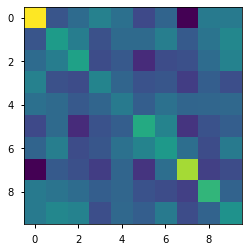

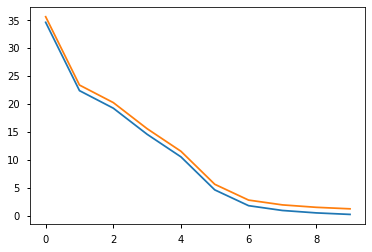

In [11]:
state_dimension = 10
D = torch.randn(size = (state_dimension, state_dimension))
M = D.mT @ D
plt.imshow(M)
U, S, Vt = torch.linalg.svd(M)
U2, S2, Vt2 = torch.linalg.svd(M + torch.eye(state_dimension))

plt.figure()
plt.plot(S)
plt.plot(S2)
print(S-S2)

In [16]:
[torch.sum((M - U[:, :rk] @ torch.diag(S[:rk]) @ Vt[:rk, :])**2) for rk in range(10)]

[tensor(2417.9976),
 tensor(1219.9459),
 tensor(719.0321),
 tensor(348.7849),
 tensor(136.5113),
 tensor(25.6910),
 tensor(4.3640),
 tensor(1.1639),
 tensor(0.2975),
 tensor(0.0505)]

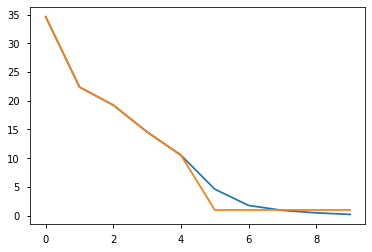

In [23]:
rk = 5
M_rk = U[:, :rk] @ torch.diag(S[:rk]-1) @ Vt[:rk, :]
plt.plot(S)
U_rk, S_rk, Vt_rk = torch.linalg.svd(M_rk + torch.eye(state_dimension))
plt.plot(S_rk)

# LMP construction

In [6]:
state_dimension = 10
rk = 5

def construct_LMP(S: torch.Tensor, AS: torch.Tensor, shift: float=1.0) -> torch.Tensor:
    In = (
        torch.eye(state_dimension)
        .reshape(-1, state_dimension, state_dimension)
        .repeat(S.shape[0], 1, 1)
    )
    StASm1 = torch.linalg.inv(torch.bmm(S.transpose(1, 2), AS))
    left = In - torch.bmm(torch.bmm(S, StASm1), AS.transpose(1, 2))
    mid = In - torch.bmm(torch.bmm(AS, StASm1), S.transpose(1, 2))
    right = torch.bmm(torch.bmm(S, StASm1), S.transpose(1, 2))
    H = torch.bmm(left, mid) + shift * right
    return H

def construct_LMP_bis(S: torch.Tensor, AS: torch.Tensor, shift: float=1.0) -> torch.Tensor:
    In = (
        torch.eye(state_dimension)
        .reshape(-1, state_dimension, state_dimension)
        .repeat(S.shape[0], 1, 1)
    )
    StASm1 = torch.linalg.inv(torch.bmm(S.transpose(1, 2), AS))
    StASm1_ = torch.linalg.inv(torch.bmm(AS.transpose(1, 2), S))
    left = In - torch.bmm(torch.bmm(S, StASm1), AS.transpose(1, 2))
    mid = In - torch.bmm(torch.bmm(AS, StASm1_), S.transpose(1, 2))
    right = torch.bmm(torch.bmm(S, StASm1), S.transpose(1, 2))
    H = torch.bmm(left, mid) + shift * right
    return H


def construct_invLMP(S: torch.Tensor, AS: torch.Tensor, shift: float=1.0) -> torch.Tensor:
    In = (
        torch.eye(state_dimension)
        .reshape(-1, state_dimension, state_dimension)
        .repeat(S.shape[0], 1, 1)
    )
    StASm1 = torch.linalg.inv(torch.bmm(S.transpose(1, 2), AS))
    B = (
        In
        + (1 / shift) * torch.bmm(torch.bmm(AS, StASm1), AS.transpose(1, 2))
        - torch.bmm(
            torch.bmm(S, torch.linalg.inv(torch.bmm(S.transpose(1, 2), S))),
            S.transpose(1, 2),
        )
    )
    return B

In [7]:
Asqrt = torch.randn(size=(1, state_dimension, state_dimension))
A = Asqrt.transpose(-1, -2).bmm(Asqrt)
S = torch.randn(size=(1, state_dimension, rk))
Sp = torch.randn(size=(1, state_dimension, rk))

tensor([[[ 0.0000e+00,  3.5763e-07,  1.1921e-07, -2.0862e-07,  1.1921e-07,
          -2.3842e-07,  0.0000e+00,  1.4901e-08, -2.9802e-08, -2.9802e-08],
         [-3.5763e-07,  0.0000e+00,  4.7684e-07, -2.3842e-07,  7.1526e-07,
          -1.1921e-06, -1.0729e-06,  8.9407e-08,  1.3113e-06, -4.7684e-07],
         [-1.1921e-07, -4.7684e-07,  0.0000e+00,  7.7486e-07, -1.1921e-07,
           5.9605e-07, -5.9605e-07, -1.7881e-07,  5.9605e-07, -2.3842e-07],
         [ 2.0862e-07,  2.3842e-07, -7.7486e-07,  0.0000e+00, -3.5763e-07,
           2.3842e-07,  9.5367e-07,  1.1921e-07, -1.0133e-06,  4.5449e-07],
         [-1.1921e-07, -7.1526e-07,  1.1921e-07,  3.5763e-07,  0.0000e+00,
           0.0000e+00, -4.7684e-07, -3.5763e-07,  3.2783e-07, -1.4901e-08],
         [ 2.3842e-07,  1.1921e-06, -5.9605e-07, -2.3842e-07,  0.0000e+00,
           0.0000e+00,  6.2585e-07,  2.3842e-07, -1.0729e-06,  4.4703e-07],
         [ 0.0000e+00,  1.0729e-06,  5.9605e-07, -9.5367e-07,  4.7684e-07,
          -6.2585e-

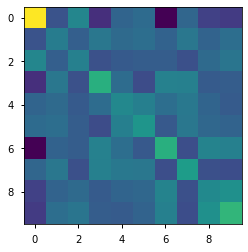

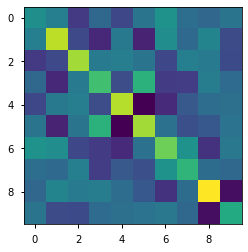

In [8]:
LMP = construct_LMP(S, A.bmm(S), shift=2)
plt.imshow(LMP.squeeze())
invLMP = construct_invLMP(S, A.bmm(S), shift=2)
plt.figure()
plt.imshow(invLMP.squeeze())
torch.sum((LMP.bmm(invLMP) - torch.eye(state_dimension))**2)
def symmetry_test(M):
    return M.transpose(-1, -2) - M
symmetry_test(LMP)
symmetry_test(invLMP)

tensor([[[ 0.0000,  0.4575, -1.2760,  0.2375, -0.1137,  0.1114,  1.5098,
           2.4269, -0.6468,  0.6801],
         [-0.4575,  0.0000, -0.1938,  0.3237, -0.6407,  0.9877,  1.0454,
           1.4580, -0.5045, -0.8879],
         [ 1.2760,  0.1938,  0.0000, -0.7675,  0.3514, -0.6163, -0.6578,
           0.2108,  0.2919,  0.2890],
         [-0.2375, -0.3237,  0.7675,  0.0000, -0.2500,  0.4181, -0.4885,
          -0.9095,  0.1943, -0.8914],
         [ 0.1137,  0.6407, -0.3514,  0.2500,  0.0000,  0.4131,  0.2699,
           0.7989, -0.6697, -0.7037],
         [-0.1114, -0.9877,  0.6163, -0.4181, -0.4131,  0.0000, -0.0300,
          -0.3347,  0.8020,  0.2478],
         [-1.5098, -1.0454,  0.6578,  0.4885, -0.2699,  0.0300,  0.0000,
          -1.8354,  0.6448,  0.5326],
         [-2.4269, -1.4580, -0.2108,  0.9095, -0.7989,  0.3347,  1.8354,
           0.0000,  0.4824,  1.5104],
         [ 0.6468,  0.5045, -0.2919, -0.1943,  0.6697, -0.8020, -0.6448,
          -0.4824,  0.0000,  0.6699],
 

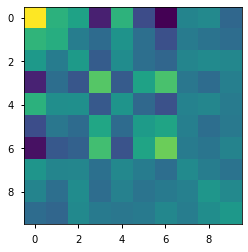

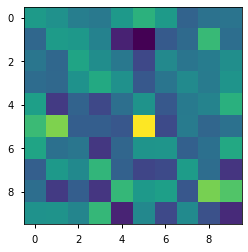

In [9]:
LMP = construct_LMP_bis(S, Sp, shift=2)
plt.imshow(LMP.squeeze())
invLMP = construct_invLMP(S, Sp, shift=2)
plt.figure()
plt.imshow(invLMP.squeeze())
symmetry_test(LMP)

# Orthonormalization of vectors

## Definition of GramSchmidt algorithm batch/non batch versions

In [10]:
# U = gram_schmidt(S[0, :-1, :].T)


def gs(V):
    def projection(u, v):
        return u * (u.dot(v) / u.norm()**2)

    def normalize(u):
        return u / u.norm()

    U = torch.zeros_like(V)
    U[:, 0] = normalize(V[:, 0])
    for i in range(1, U.shape[1]):
        print(f"{i=}")
        U[:, i] = V[:, i].clone()
        for j in range(i):
            print(f"  {j=}")
            U[:, i] -= projection(U[:, j], V[:, i])
        U[:, i] = normalize(U[:, i])
    return U
    
bU = torch.randn(size=(4, 6))
bV= torch.randn(size=(4, 6))


def bgs(bV):
    """Batch orthonormalisation of rank vectors, each of dimension ndim
    bV.shape = [batch, ndim, rank]
    """
    def bnormalize(V):
        return V / V.norm(dim=1).view(V.shape[0], 1)
        
    def bproj(bU, bV):
        return (torch.einsum("bn,bn->b", bU, bV) / bU.norm(dim=1)**2).view(bU.shape[0], 1) * bU
    bU = torch.zeros_like(bV)
    bU[:, :, 0] = bnormalize(bV[:, :, 0])
    for i in range(1, bU.shape[-1]):
        bU[:, :, i] = bV[:, :, i].clone()
        for j in range(i):
            bU[:, :, i] -= bproj(bU[:, :, j], bV[:, :, i])
        bU[:, :, i] = bnormalize(bU[:, :, i])
    return bU

## Construction of deflated preconditioners

vi.shape=torch.Size([8, 20, 5])
li.shape=torch.Size([8, 5])
vi.bmm(vi.transpose(-1, -2)).shape=torch.Size([8, 20, 20])
torch.Size([8, 20, 20])
k=0, -k-1=-1
k=1, -k-1=-2
k=2, -k-1=-3
k=3, -k-1=-4
k=4, -k-1=-5


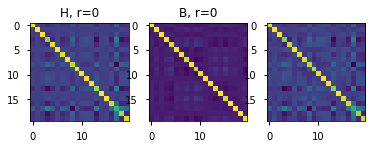

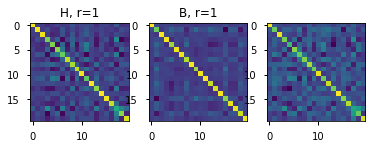

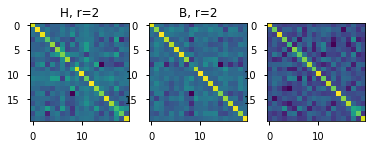

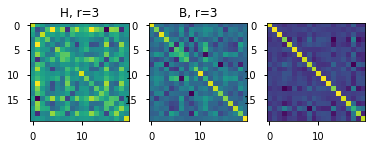

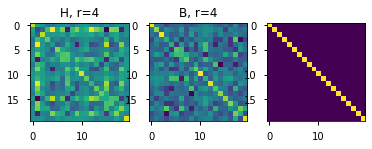

In [11]:
batch_size = 8
state_dimension = 20
rank = 5

identity = (
            torch.eye(state_dimension)
            .reshape(-1, state_dimension, state_dimension)
            .repeat(batch_size, 1, 1)
        )

S = torch.randn(size = (batch_size, state_dimension + 1, rank))
vi, li = S[:, :-1, :], S[:, -1, :]
vi = bgs(vi)
print(f"{vi.shape=}")
print(f"{li.shape=}")

print(f"{vi.bmm(vi.transpose(-1, -2)).shape=}")
coeffs_H = 1 - (1 / li)
coeffs_B = (1 - li)
H = identity.clone()
B = identity.clone()
print(H.shape)
for k in range(rank):
    print(f"{k=}, {-k-1=}")
    batchmm = (vi[:, :, k].view(batch_size, state_dimension, 1).bmm(vi[:, :, k].view(batch_size, state_dimension, 1).transpose(-2, -1)))
    batchmm_bck = (vi[:, :, -k-1].view(batch_size, state_dimension, 1).bmm(vi[:, :, -k-1].view(batch_size, state_dimension, 1).transpose(-2, -1)))

    H = H.bmm(identity - coeffs_H[:, k].view(batch_size, 1, 1) * batchmm)
    B = B.bmm(identity - coeffs_B[:, -k-1].view(batch_size, 1, 1) * batchmm_bck)
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.title(f"H, r={k}")
    plt.imshow(H[2,:, :])
    plt.subplot(1, 3, 2)
    plt.title(f"B, r={k}")
    plt.imshow(B[2, :, :])
    plt.subplot(1, 3, 3)
    plt.imshow(H[2, :, :] @ B[2, :, :])

i=1
  j=0
i=2
  j=0
  j=1
i=3
  j=0
  j=1
  j=2
i=4
  j=0
  j=1
  j=2
  j=3
vi.shape=torch.Size([20, 5])
li.shape=torch.Size([5])
torch.Size([20, 20])
k=0, -k-1=-1
torch.Size([20, 20])
torch.Size([20, 20])
tensor(2.1034)
H.shape=torch.Size([20, 20])
k=1, -k-1=-2
torch.Size([20, 20])
torch.Size([20, 20])
tensor(4.0836)
H.shape=torch.Size([20, 20])
k=2, -k-1=-3
torch.Size([20, 20])
torch.Size([20, 20])
tensor(6.0287)
H.shape=torch.Size([20, 20])
k=3, -k-1=-4
torch.Size([20, 20])
torch.Size([20, 20])
tensor(0.1558)
H.shape=torch.Size([20, 20])
k=4, -k-1=-5
torch.Size([20, 20])
torch.Size([20, 20])
tensor(-2.4293)
H.shape=torch.Size([20, 20])


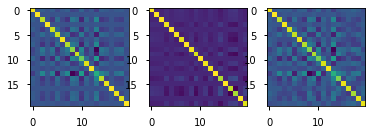

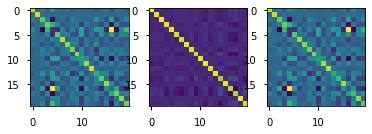

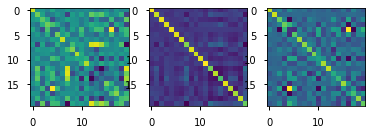

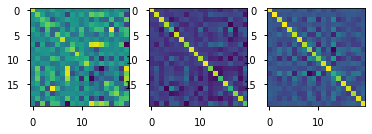

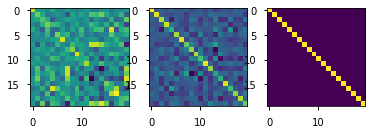

In [12]:
vi, li = S[0, :-1, :], S[0, -1, :]
vi = gs(vi)

print(f"{vi.shape=}")
print(f"{li.shape=}")

coeffs_H = 1 - (1 / li)
coeffs_B = (1 - li)
H = torch.eye(state_dimension)
B = torch.eye(state_dimension)

acc = torch.eye(state_dimension)
for k in range(rank):
    acc -= coeffs_H[k] * (vi[:, k].view(state_dimension, 1).mm(vi[:, k].view(state_dimension, 1).T))

print(H.shape)
for k in range(rank):
    print(f"{k=}, {-k-1=}")
    batchmm = (vi[:, k].view(state_dimension, 1).mm(vi[:, k].view(state_dimension, 1).T))
    print(batchmm.shape)
    batchmm_bck = (vi[:, -k-1].view(state_dimension, 1).mm(vi[:, -k-1].view(state_dimension, 1).T))
    print(batchmm_bck.shape)
    print(coeffs_H[k])
    H = H @ (torch.eye(state_dimension) - coeffs_H[k] * batchmm)
    B = B @ (torch.eye(state_dimension) - coeffs_B[-k-1] * batchmm_bck)
    print(f"{H.shape=}")
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(H)
    plt.subplot(1, 3, 2)
    plt.imshow(B)
    plt.subplot(1, 3, 3)
    plt.imshow(H @ B)

In [13]:
S = torch.randn(size = (batch_size, state_dimension + 1, rank))
vi, li = S[:, :-1, :], S[:, -1, :]
q_i = torch.linalg.qr(vi)[0]

def btransp(tens):
    return tens.transpose(-1, -2)

def outer_prod_rk(q, rk):
    vv = q[:, :, rk].view(batch_size, state_dimension, 1)
    return (vv.bmm(btransp(vv)))

def construct_deflation(q, coeff):
    H = identity.clone()
    for k in range(q.shape[-1]):
        H = H.bmm(identity - coeff[:, k].view(batch_size, 1, 1) * outer_prod_rk(q, k))
    return H

def construct_deflation_backward(q, coeff):
    H = identity.clone()
    for k in range(q.shape[-1]):
        H = H.bmm(identity - coeff[:, -k-1].view(batch_size, 1, 1) * outer_prod_rk(q, k))
    return H


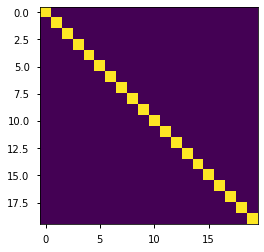

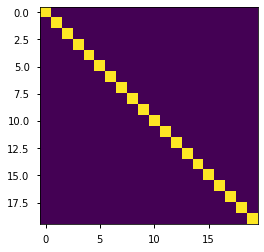

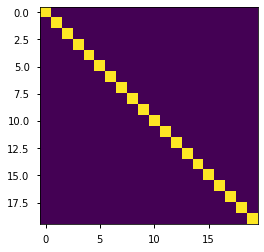

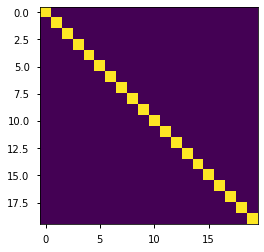

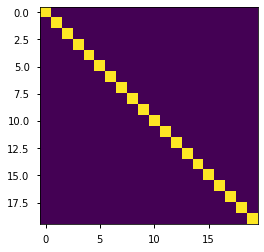

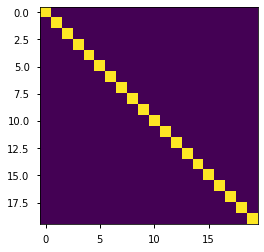

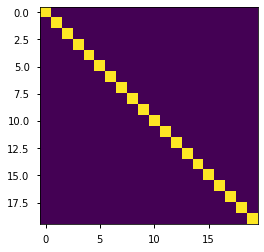

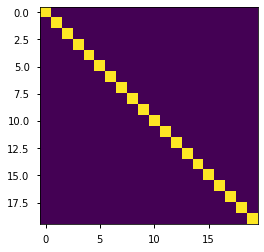

In [14]:
coeffs_H = 1 - (1 / li)
coeffs_B = (1 - li)

H_def = construct_deflation(q_i, coeffs_H)
B_def = construct_deflation(q_i, coeffs_B)

for i in range(batch_size):
    plt.figure()
    plt.imshow(H_def.bmm(B_def)[i, ...])

q_i.shape=torch.Size([8, 20, 5])
H.shape=torch.Size([8, 20, 20])
k=0, -k-1=-1
k=1, -k-1=-2
k=2, -k-1=-3
k=3, -k-1=-4
k=4, -k-1=-5


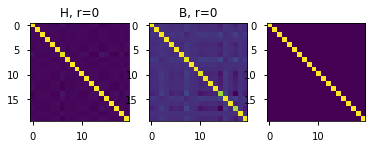

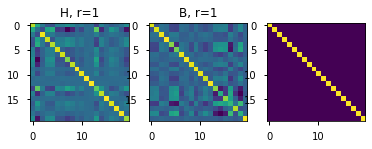

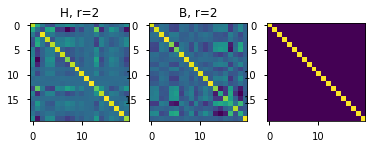

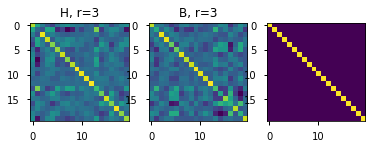

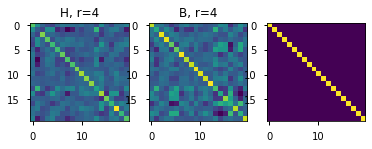

In [15]:

S = torch.randn(size = (batch_size, state_dimension + 1, rank))
vi, li = S[:, :-1, :], S[:, -1, :]

q_i = torch.linalg.qr(vi)[0]
print(f"{q_i.shape=}")

coeffs_H = 1 - (1 / li)
coeffs_B = (1 - li)
H = identity.clone()
B = identity.clone()
Bp = identity.clone()
print(f"{H.shape=}")
for k in range(rank):
    print(f"{k=}, {-k-1=}")
    batchmm = outer_prod_rk(q_i, k)
    batchmm_bck = outer_prod_rk(q_i, -k-1)

    H = H.bmm(identity - coeffs_H[:, k].view(batch_size, 1, 1) * batchmm)
    B = B.bmm(identity - coeffs_B[:, -k-1].view(batch_size, 1, 1) * batchmm_bck)
    Bp = Bp.bmm(identity - coeffs_B[:, k].view(batch_size, 1, 1) * batchmm)
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.title(f"H, r={k}")
    plt.imshow(H[2,:, :])
    plt.subplot(1, 3, 2)
    plt.title(f"B, r={k}")
    plt.imshow(B[2, :, :])
    plt.subplot(1, 3, 3)
    plt.imshow(H[2, :, :] @ Bp[2, :, :])





In [132]:

out = torch.randn(size=(batch_size, state_dimension+1, k))
S, l = out[:, :-1, :], out[:, -1, :]
S.shape, l.shape
orth_S = torch.linalg.qr(S)[0]
mu = torch.exp(l)
def construct_mat(orth_S, mu):
    identity = torch.eye(state_dimension).view(1, state_dimension, state_dimension).expand(batch_size, -1, -1)
    sm = 0
    for i in range(k):
        wi = orth_S[:, :, i].view(batch_size, state_dimension, 1)
        sm += (mu[:, i].view(batch_size, 1, 1)-1) * (wi.bmm(btransp(wi)))
    return sm + identity

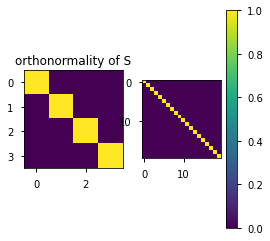

In [137]:
# mu = torch.ones(size=(1, 4))
mat = construct_mat(orth_S, mu)
mat2 = construct_mat(orth_S, 1/mu)

plt.subplot(1, 3, 1)
plt.imshow(btransp(orth_S).bmm(orth_S)[0, ...])
plt.title('orthonormality of S')
plt.subplot(1, 3, 2)
plt.imshow(mat.bmm(mat2)[, ...])
plt.colorbar()

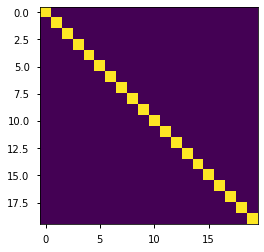

In [129]:
sm = torch.eye(state_dimension).view(1, state_dimension, state_dimension).expand(batch_size, -1, -1)

plt.imshow(sm[6, ...])

# Iterable Datasets

forward call
(tensor([ 0.2517,  2.0307,  0.2780, -1.0087,  1.2001,  2.9094,  0.9864,  0.1043,
         0.0532,  1.3536, -0.2614, -0.1486,  0.7930, -0.2310,  0.2267,  0.4756,
        -0.4036,  0.6204,  0.2100,  1.8552,  2.5607, -0.0994,  1.0683,  0.4219,
         1.7070, -0.6837,  0.7652,  0.2824,  0.8845,  0.3811, -0.0726, -0.1808,
         1.4235, -0.4580,  1.4827,  0.7458,  0.8926,  1.4046,  0.8400,  1.2459,
         0.9006,  1.2462,  2.3337,  0.2333,  0.1086,  2.8669,  0.5288,  0.9599,
         0.7963,  0.2779]), tensor([[-1.5307, -1.3078, -0.7543, -0.8732, -0.5393],
        [ 0.9954, -1.0766,  0.6744, -0.2527, -1.0389],
        [-0.2060,  1.2313,  1.5840, -0.9167, -0.0052],
        [-0.4437,  0.8761, -2.5670, -1.9152,  2.8923],
        [-0.6555,  0.1084,  1.2115,  0.0195, -0.9145],
        [ 2.2289, -0.5085, -0.1094, -1.0827, -0.9433],
        [ 1.2045,  0.0214, -1.3481,  1.9207,  0.9426],
        [-0.0483, -1.7558, -0.4149,  0.8013, -0.7037],
        [-0.3844,  0.4426,  0.6134,  1

KeyboardInterrupt: 

In [ ]:
it_module = LorenzTLVectorIterableDataModule(
    state_dimension=40,
    nobs=10,
    len_dataset=5,
    nvectors=10,
    batch_size=32,
    num_workers=1,
    shuffling=False,
    full_jacobian=True,
    persistent_workers=True,
)
it_module.setup(None)

Train dataset initialized
Validation dataset initialized
Test dataset initialized


In [ ]:
it_module.train_dataloader()


In [ ]:
class DummyIterableDataset(IterableDataset):
    def __init__(self, st) -> None:
        super().__init__()
        print(f"{st=}")
        self.current_x = 0

    def __iter__(self):
        self.generated=1
        return self

    def __next__(self):
        if self.generated > 50:
            raise StopIteration
        x = self.generated + 0.2 * torch.randn(size=(1,))
        self.generated += 1
        self.current_x = x
        print("next called")
        return x

class DummyIterableDataModule(pl.LightningDataModule):
    def __init__(self):
        super().__init__()
    
    def setup(self, stage = None) -> None:
        self.train_iter_dataset = DummyIterableDataset("train")
        self.val_iter_dataset = DummyIterableDataset("val")
        self.iter_iter_dataset = DummyIterableDataset("iter")
        return super().setup(stage)

    def train_dataloader(self):
        return DataLoader(self.train_iter_dataset, batch_size=5, num_workers=1, persistent_workers=True)

    def val_dataloader(self):
        return DataLoader(self.val_iter_dataset, batch_size=5, num_workers=1, persistent_workers=True)

    def test_dataloader(self):
        return DataLoader(self.test_iter_dataset, batch_size=5, num_workers=1, persistent_workers=True)

dummy_dataset = DummyIterableDataset("dummy dataset")
du_datamodule = DummyIterableDataModule()

st='dummy dataset'


In [ ]:
du_datamodule.setup()

st='train'
st='val'
st='iter'


In [ ]:
torch.randn(size=(1,))

tensor([-1.4392])

In [ ]:
for j, i in enumerate(iter(du_datamodule.train_dataloader())):
    print(j, i)


next called
next called
next called
next called
next called
next called
next called
next called
next called
next called
next called
next called
next called
next called
next called
next called
next called
next called
next called
next called
next called
next called
next called
next called
next called
next called
next called
next called
next called
next called
next called
next called
next called
next called
next called
next called
next called
next called
next called
next called
next called
next called
next called
next called
next called
next called
next called
next called
next called
next called
0 tensor([[0.8124],
        [1.9604],
        [3.3664],
        [3.9643],
        [4.9051]])
1 tensor([[ 5.9920],
        [ 7.2012],
        [ 8.3023],
        [ 8.7082],
        [10.1947]])
2 tensor([[10.6237],
        [12.0843],
        [12.7223],
        [14.3225],
        [15.2665]])
3 tensor([[15.6898],
        [17.3164],
        [17.6330],
        [19.0039],
        [19.7759]])
4 tensor([[20

NameError: name 'gen' is not defined

In [ ]:
for i in (map(lambda x: x.shape, [x, dx, GtGdx])):
    print(i)

torch.Size([32, 40])
torch.Size([32, 40, 40])
torch.Size([32, 40, 40])


In [ ]:
gen = iter(it_module.train_dataloader().dataset)


In [ ]:
a = next(gen)


forward call


In [ ]:
b = next(gen)

forward call


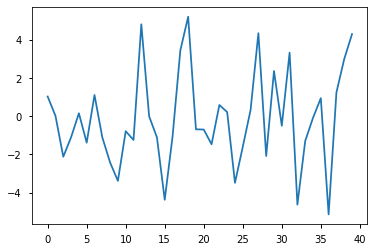

In [ ]:
plt.plot(a[0] - b[0])

# Randomised Eigenvalue decomposition

In [ ]:
def REVD(A, k, l):
    n_a = A.shape[-1]
    G = torch.randn(size=(n_a, k + l))
    Y = A @ G
    Z = torch.linalg.qr(Y)[0]
    K1 = Z.transpose(-1, -2) @ A @ Z
    print(K1.shape)
    eigvals, eigvecs = torch.linalg.eigh(K1)
    eigvals = eigvals.flip(-1)[:k]
    eigvecs = eigvecs.flip(-1)[:, :k]
    U = Z @ eigvecs
    return eigvals, U

def REVD_Nystrom(A, k, l):
    n_a = A.shape[-1]
    G = torch.randn(size=(n_a, k + l))
    Y = A @ G
    Z = torch.linalg.qr(Y)[0]
    E1 = A @ Z
    E2 = Z.transpose(-1, -2) @ E1
    L = torch.linalg.cholesky(E2)
    F = torch.linalg.solve(L, E1.transpose(-2, -1)).transpose(-1, -2)
    U, S, Vt = torch.linalg.svd(F)
    return S[:k]**2, U[:, :k]

def REVD_ritzit(A, k, l):
    n_a = A.shape[-1]
    G = torch.randn(size=(n_a, k + l))
    Y = A @ G
    Z, R = torch.linalg.qr(Y)
    K = R @ R.transpose(-1, -2)
    eigvals, eigvecs = torch.linalg.eigh(K)
    eigvals = eigvals.flip(-1)[:k]
    eigvecs = eigvecs.flip(-1)[:, :k]    
    return torch.sqrt(eigvals), eigvecs

In [ ]:
A = torch.randn(size=(10, 10))
A = A.T @ A

In [ ]:
eigvals, eigvecs = REVD(A, 3, 20)
print(A @ eigvecs - eigvals * eigvecs)
eigvals, eigvecs = REVD_Nystrom(A, 3, 20)
print(A @ eigvecs - eigvals * eigvecs)
eigvals, eigvecs = REVD_ritzit(A, 5, 50)
print(A @ eigvecs - eigvals * eigvecs)

torch.Size([10, 10])
tensor([[-8.1062e-06,  4.2915e-06, -4.7684e-07],
        [-5.7220e-06,  0.0000e+00,  4.7684e-06],
        [ 4.7684e-06,  2.3842e-06,  4.2915e-06],
        [ 1.9073e-06,  4.7684e-06, -1.1921e-06],
        [ 3.8147e-06, -4.2915e-06,  3.8147e-06],
        [ 1.9073e-06, -1.4305e-06,  0.0000e+00],
        [ 4.1202e-06,  7.6294e-06,  6.3181e-06],
        [ 3.8147e-06, -1.9073e-06,  3.0994e-06],
        [-3.0994e-06, -9.5367e-06, -9.5367e-07],
        [ 9.5367e-07,  3.8147e-06,  1.4305e-06]])
tensor([[ 1.9073e-06,  0.0000e+00,  4.2915e-06],
        [ 2.3842e-06, -5.7220e-06, -3.3379e-06],
        [-9.5367e-07, -1.9073e-06,  2.3842e-07],
        [-1.9073e-06,  1.9073e-06,  3.5763e-06],
        [ 1.9073e-06, -2.8610e-06,  0.0000e+00],
        [ 3.8147e-06, -3.8147e-06,  3.8147e-06],
        [-2.9057e-06, -1.9073e-06, -1.1921e-07],
        [ 0.0000e+00,  9.5367e-06, -4.7684e-07],
        [ 5.7220e-06, -2.8610e-06, -4.7684e-06],
        [-1.3351e-05,  1.1444e-05, -4.7684e-06]

In [ ]:
eigvals

tensor([10.4877, 14.0127, 17.8396, 34.3829, 34.7930])

tensor([[ 0.4205, -0.1803, -0.4705],
        [-0.0801,  0.7901,  0.0766],
        [-0.1836,  1.2135, -0.0216],
        [ 0.0664,  0.5969, -0.3684],
        [ 0.5485,  0.6684, -0.2545],
        [ 0.4904,  2.0215, -0.1210],
        [ 0.6021, -0.5554, -0.3582],
        [ 0.5151,  2.2378, -0.2847],
        [-0.0101, -0.1690, -0.0041],
        [ 0.2342,  1.4263, -0.1436]])